In [1]:
from plot import *

# Workload Balancing Techiques

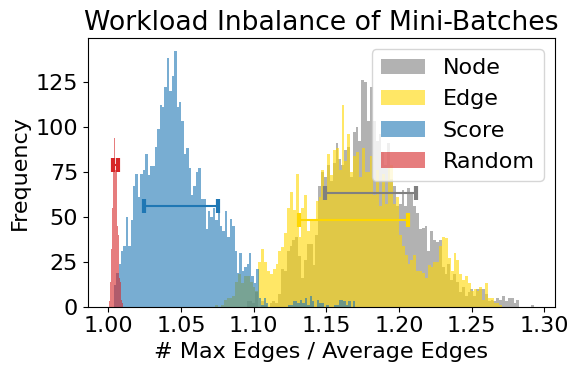

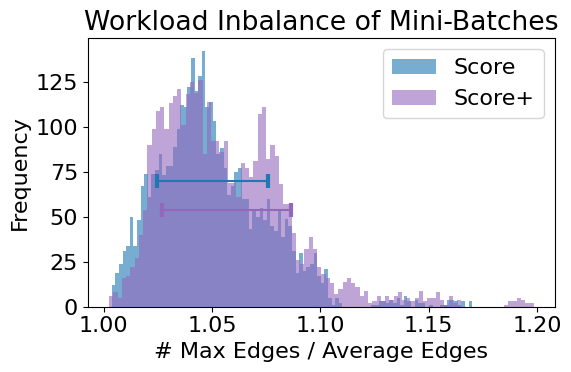

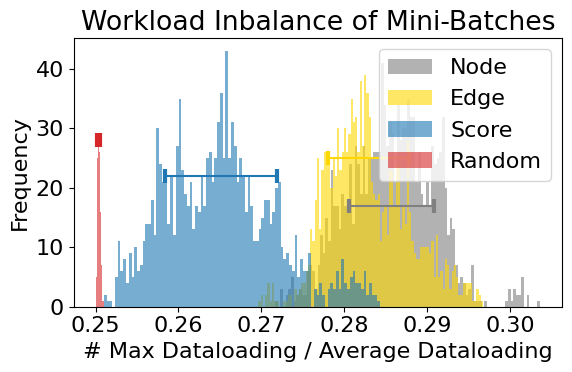

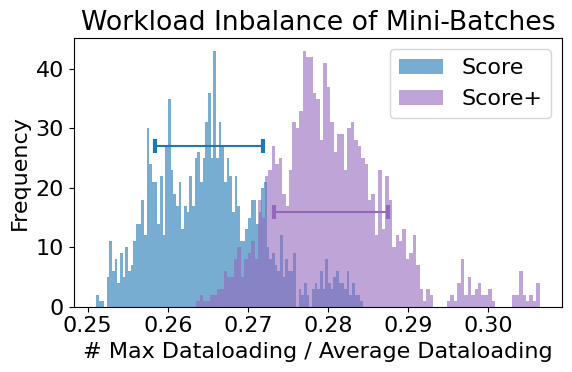

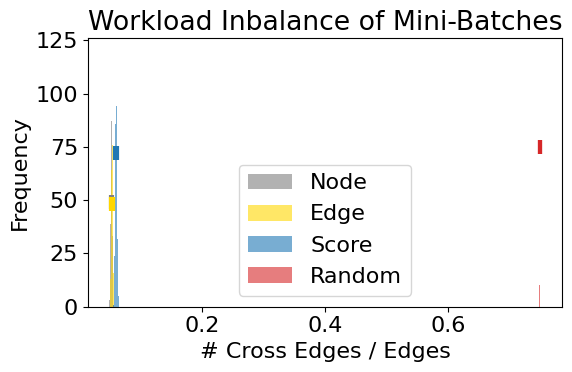

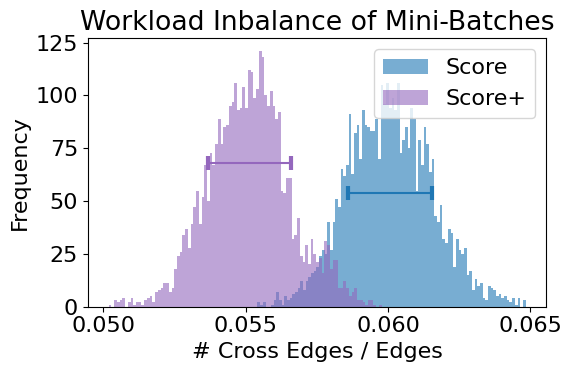

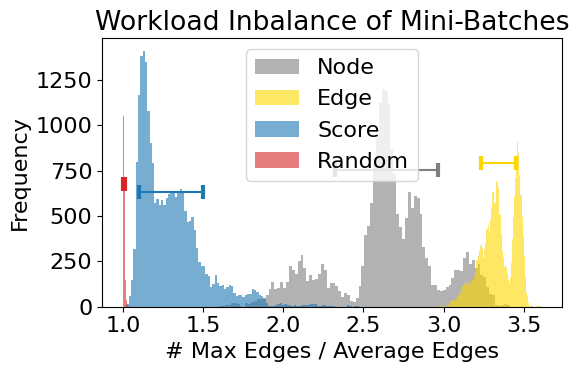

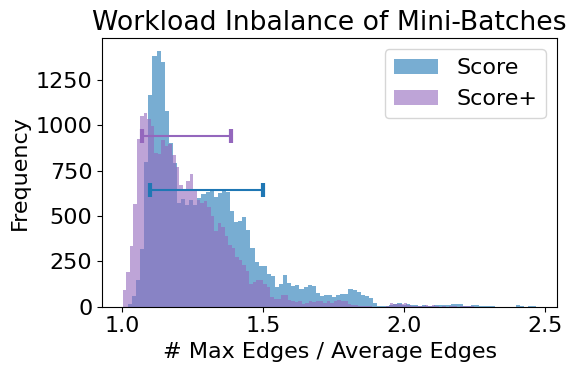

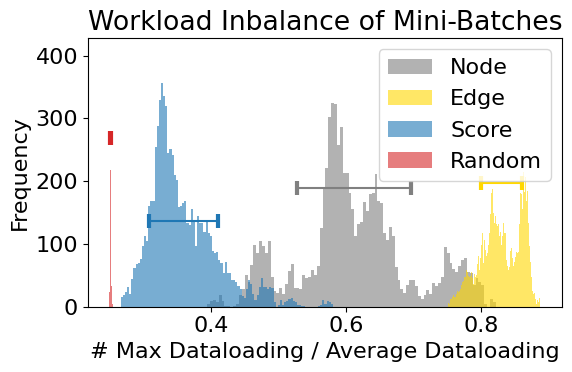

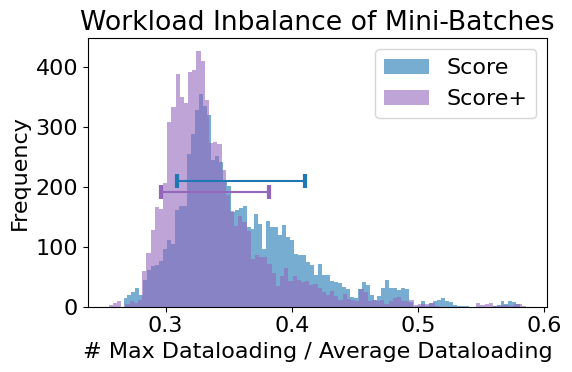

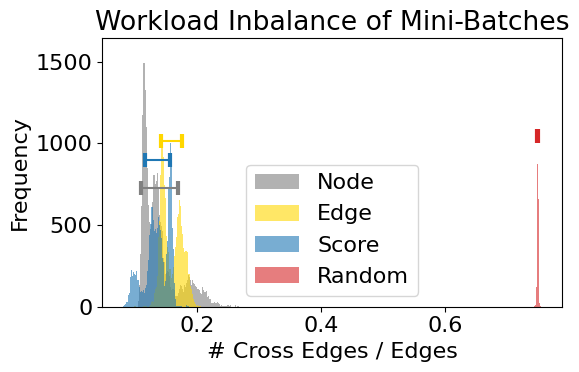

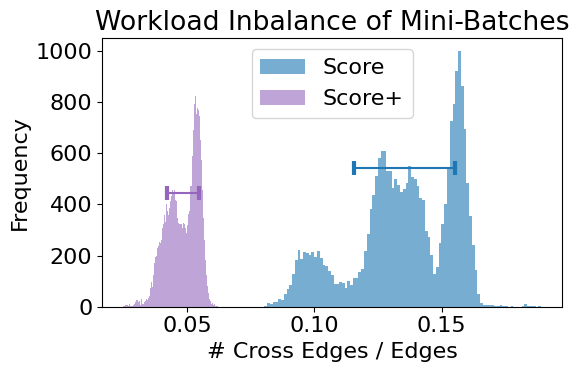

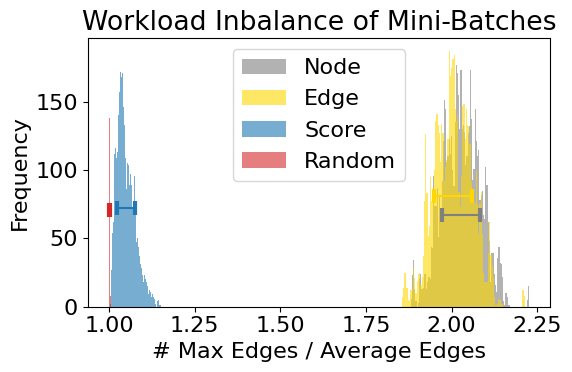

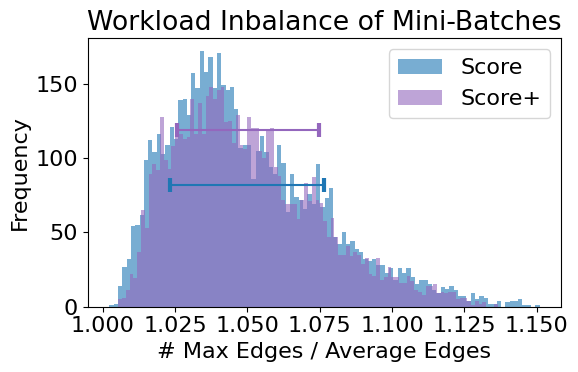

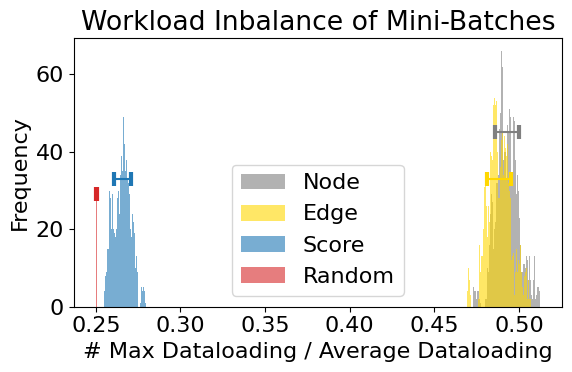

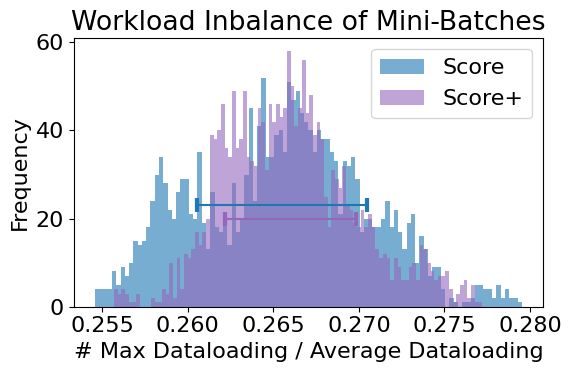

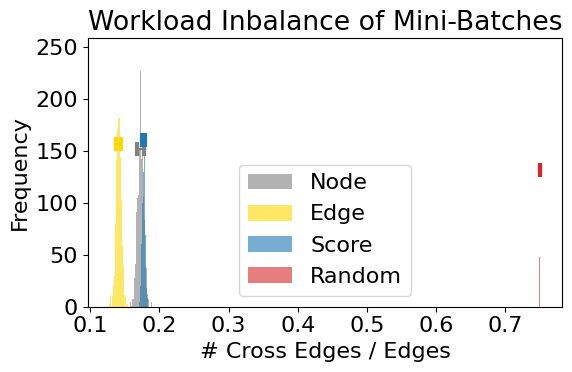

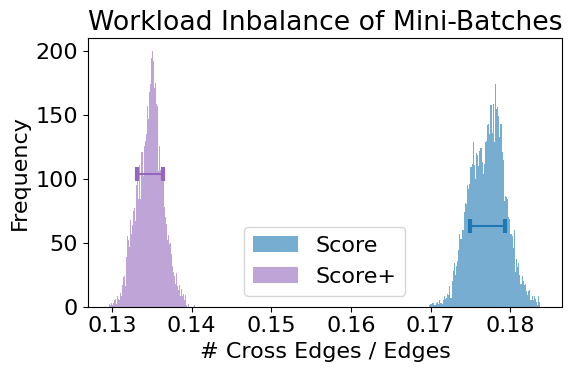

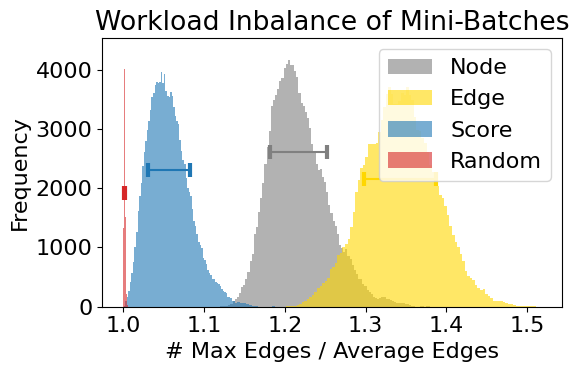

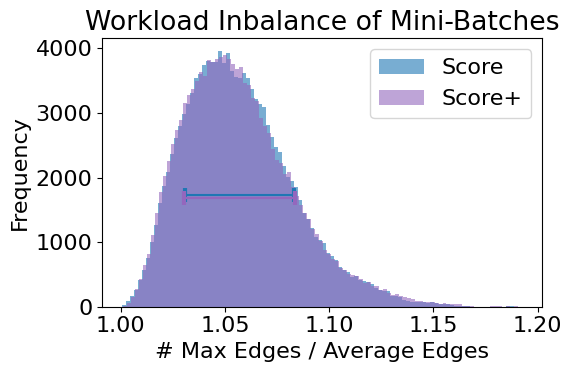

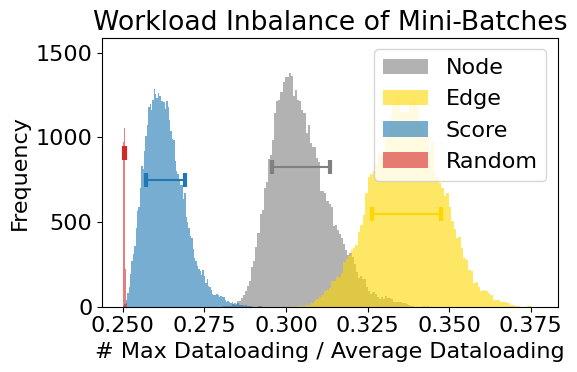

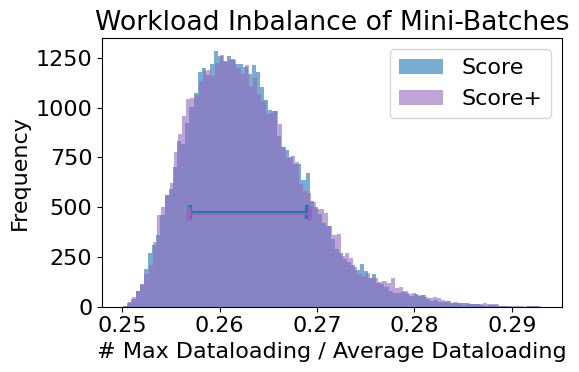

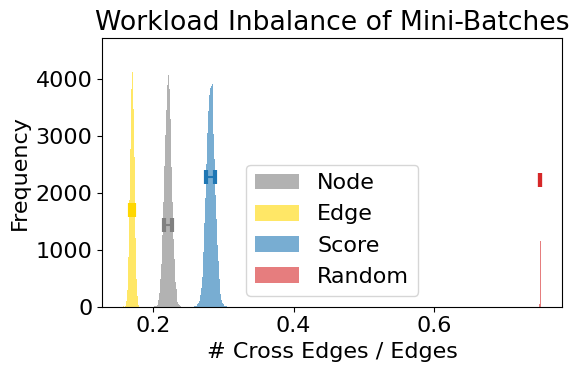

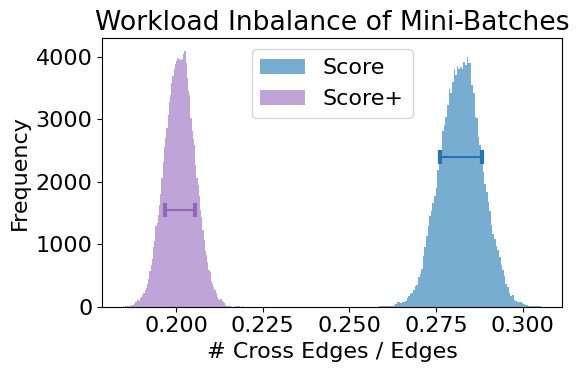

In [2]:
def get_workload_bal(graph_name, data_dir):
    name2work = {}
    pcfgs = []

    #baseline
    for node_mode in ["uniform", "degree"]:
        pcfg = ParConfig(node_mode=node_mode, edge_mode="uniform", bal="bal")
        pcfgs.append(pcfg)

    #freq based workload balancing
    for node_mode in ["dst"]:
        for edge_mode in ["uniform"]:
            for bal in ["xbal"]:
                pcfg = ParConfig(node_mode=node_mode, edge_mode=edge_mode, bal=bal)
                pcfgs.append(pcfg)
    pcfg = ParConfig(node_mode="random", edge_mode="random", bal="xbal")
    pcfgs.append(pcfg)
    for pcfg in pcfgs:
        workload = load_workload(graph_name, data_dir, pcfg)
        name2work[pcfg.name()] = workload
    return name2work

def get_workload_comm(graph_name, data_dir):
    name2work = {}
    pcfgs = []
    #baseline
    # for node_mode in ["uniform", "degree"]:
    #     pcfg = ParConfig(node_mode=node_mode, edge_mode="uniform", bal="bal")
    #     pcfgs.append(pcfg)
        
    for node_mode in ["dst"]:
        for edge_mode in ["uniform", "freq"]:
            for bal in ["xbal"]:
                pcfg = ParConfig(node_mode=node_mode, edge_mode=edge_mode, bal=bal)
                pcfgs.append(pcfg)
    # pcfg = ParConfig(node_mode="random", edge_mode="random", bal="xbal")
    pcfgs.append(pcfg)
    for pcfg in pcfgs:
        workload = load_workload(graph_name, data_dir, pcfg)
        name2work[pcfg.name()] = workload
    return name2work

data_dir = "/data/juelin/dataset/gsplit"
for graph_name in ["products", "papers100M", "orkut", "friendster"]:
# for graph_name in ["products"]:
    name2work_bal = get_workload_bal(graph_name, data_dir)
    name2work_comm = get_workload_comm(graph_name, data_dir)
    for plot_mode in ["edge", "input", "crs"]:
    # for plot_mode in ["edge"]:
        plots(name2work_bal, plot_mode, f"plots/{graph_name}_{plot_mode}_bal.png")
        plots(name2work_comm, plot_mode, f"plots/{graph_name}_{plot_mode}_com.png")
